<a href="https://colab.research.google.com/github/Gorodecki/Projects/blob/master/NLP_NER_News.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# NER задача на базе новостей

In [ ]:
import numpy as np
import pandas as pd

from tensorflow.keras.layers import Dense, SimpleRNN, Concatenate, Input, concatenate, LSTM, Embedding, BatchNormalization, Dropout, Bidirectional, GlobalMaxPool1D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import AUC, Accuracy
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping

import io
import re
from google.colab import drive
import sklearn
from sklearn.metrics import roc_curve, auc, classification_report
import matplotlib.pyplot as plt
colors_map = plt.rcParams['axes.prop_cycle'].by_key()['color']
%matplotlib inline

In [ ]:
drive.mount('/content/drive')
%cd '/content/drive/My Drive/Colab Notebooks/NLP course/Данные/News_NLP_4/'
!ls

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/Colab Notebooks/NLP course/Данные/News_NLP_4
 news_1.xml  'База новостей часть 1.docx'
 news_2.xml  'База новостей. часть 2.docx'


#Парсим файлы формата XML (.docx)

In [ ]:
import xml.etree.ElementTree as ET

In [ ]:
color_meaning = {'00ff00':'сравнение', '00ffff':'дальность', '9900ff':'эмоции', 'ff00ff':'комфорт', 'ffff00':'скорость',
                'green':'сравнение', 'yellow':'скорость', 'cyan':'дальность', 'magenta':'комфорт'} #создаем словарь соответствий цвет-значение

In [ ]:
#названия необходимых тегов
r = '{http://schemas.openxmlformats.org/wordprocessingml/2006/main}r'
rpr = '{http://schemas.openxmlformats.org/wordprocessingml/2006/main}rPr'
t = '{http://schemas.openxmlformats.org/wordprocessingml/2006/main}t'
shd = '{http://schemas.openxmlformats.org/wordprocessingml/2006/main}shd'
fill = '{http://schemas.openxmlformats.org/wordprocessingml/2006/main}fill'
highlight = '{http://schemas.openxmlformats.org/wordprocessingml/2006/main}highlight'
val = '{http://schemas.openxmlformats.org/wordprocessingml/2006/main}val'

In [ ]:
#парсим tesla_1
tree = ET.parse('news_1.xml')
root = tree.getroot()
body = root[0]
ps1 = list(iter(body))[:-1]

In [ ]:
#парсим tesla_2
tree = ET.parse('news_2.xml') #открываем xml файл
root = tree.getroot() #находим корень
body = root[0]
ps2 = list(iter(body))[:-1] #получаем список всех отзывов

In [ ]:
news_all = ps1 + ps2

In [ ]:
#Сведем все в кучу для токенайзера
all_txt=[]

for paragraph in ps1: # отзывы из 1 блока
    phrases_list = paragraph.findall(r)
    text=''
    for phrase in phrases_list:
        text+= phrase.find(t).text
    all_txt.append(text)

for paragraph in ps2: # отзывы из 2 блока
    phrases_list = paragraph.findall(r)
    text=''
    for phrase in phrases_list:
        text+= phrase.find(t).text
    all_txt.append(text)

print('Количество отзывов:', len(all_txt))
all_txt[100]

Количество отзывов: 3518


'Волка подозревают в нападении на загон с кенгуру на севере Бельгии, одно животное погибло, другое было ранено, пишет местная газета Soir со ссылкой на природоохранную организацию Landschap. Инцидент произошел в ночь на среду в коммуне Бален (провинция Антверпен). Подвергшиеся нападению кенгуру проживали в служившем им загоном саду рядом с домом владельца. По мнению экспертов Landschap и кампании Welkom Wolf ("Добро пожаловать, волк"), нападение совершил волк Август, который во вторник был замечен в районе коммуны. Согласно наблюдениям натуралистов, за прошедшие несколько недель хищник также задрал несколько овец, принадлежавших местным фермерам. Представитель Landschap Ян Лос убежден, что на кенгуру напал именно волк. "Волк проскользнул под решеткой загона и утащил кенгуру", — сказал он изданию, добавив, что речь идет об Августе или, что менее вероятно, появившемся в регионе новом волке.'

In [ ]:
# PyMorphy используем для нормализации форм слов (чтобы не раздувать num_character, а соответственно Embedding)
!pip install pymorphy2 
import pymorphy2
morph = pymorphy2.MorphAnalyzer()

In [ ]:
# Пересобираем текст в нормальной форме
def morphy_clean(text):
  '''
  функция возвращает list слов в нормальной форме, в расчёт не берём "NUMR - числительное, PREP - предикатив, CONJ - предлог, PRCL - союз, INTJ - частица или междометие" 
  '''
  for i in range(len(text)):
    # генератор перебирает слова внутри i-го предложения, собираем через пробел в строку
    text[i]=' '.join([morph.parse(word.replace('.',''))[0].normal_form for word in text[i].split() if morph.parse(word.replace('.',''))[0].tag.POS not in ('NUMR','PREP','CONJ','PRCL','INTJ')])
  return text

In [ ]:
# смешно, но как будто пишет человек иностранец, не знающий русский язык )))
all_txt = morphy_clean(all_txt)
all_txt[100]

'волк подозревать нападение загон кенгуру север бельгии, один животный погибло, другой быть ранено, писать местный газета soir ссылка природоохранный организация landschap инцидент произойти ночь среда коммуна бальный (провинция антверпен) подвергнуться нападение кенгуру проживать служить имя загон сад ряд дом владелец мнение эксперт landschap кампания welkom wolf ("добро пожаловать, волк"), нападение совершить волк август, который вторник быть заметить район коммуна наблюдение натуралистов, прошедшее несколько неделя хищник задрать несколько овец, принадлежать местный фермер представитель landschap ян лос убежден, кенгуру напасть волк "волк проскользнуть решётка загон утащить кенгуру", — сказать он изданию, добавив, речь идти август или, менее вероятно, появиться регион новый волк'

In [ ]:
# создаем словарь частотности по всему тексту исключая знаки
num_characters = 15000
tokenizer = Tokenizer(num_words=num_characters, filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n', oov_token='<unk>') #токенизируем на уровне слов
tokenizer.fit_on_texts(np.array(all_txt)) #формируем токены на основе частотности в нашем тексте
tok_ind = tokenizer.word_index # выводим сколько всего уникальных слов
print(len(tok_ind))
[_ for _ in tok_ind.items() if _[0] in ['город', 'правительство', 'человек', 'управление', 'депутат', 'россия']] # генератор по словарю, по нескольким ключам

29230


[('россия', 11),
 ('человек', 21),
 ('город', 40),
 ('правительство', 48),
 ('управление', 319),
 ('депутат', 399)]

In [ ]:
# словарь всех цветов встречающихся в тексте
colors = set()

In [ ]:
# функция вычисления всех встретившихся цветов в тексте --->>> потом смотрим эти цвета в файле и создаём словарь соответствия "Цвет - Окраска"
def colors_in_doc(doc):
  for i, paragraph in enumerate(doc):
    phrases_list = paragraph.findall(r)
    for phrase in phrases_list:
        text = phrase.find(t).text
        style = phrase.find(rpr)
        
        if style.find(shd) is not None:
            color = style.find(shd).attrib[fill]
        elif style.find(highlight) is not None:
            color = style.find(highlight).attrib[val]
        else:
            color = 'white'
        color = color.lower()
        
        colors.add(color)
        
  print(colors)

In [ ]:
colors_in_doc(ps1)

{'ffffff', 'cccccc', '00ff00', 'ffff00', '9900ff', '674ea7', 'd9d9d9', '00ffff', 'b4a7d6', 'fff2cc', 'efefef', 'white', 'ff00ff', '8e7cc3', '999999', 'c27ba0'}


In [ ]:
colors_in_doc(ps2)

{'00ff00', 'd9d9d9', 'b4a7d6', 'efefef', 'ff00ff', 'yellow', '999999', 'c27ba0', 'ffffff', '9900ff', 'b7b7b7', '674ea7', '00ffff', 'white', 'cyan', 'cccccc', 'ffff00', 'fff2cc', 'green', '8e7cc3', 'magenta'}


In [ ]:
colors = list(colors)
colors

['00ff00',
 'd9d9d9',
 'b4a7d6',
 'efefef',
 'ff00ff',
 'yellow',
 '999999',
 'c27ba0',
 'ffffff',
 '9900ff',
 'b7b7b7',
 '674ea7',
 '00ffff',
 'white',
 'cyan',
 'cccccc',
 'ffff00',
 'fff2cc',
 'green',
 '8e7cc3',
 'magenta']

In [ ]:
# создаём словарь окраски
index_color = ['Пусто', 'Личность', 'Локация', 'Организация, группа', 'Дата', 'Национальность', 'Звание, профессия, чин']

# передаём привет тем кто размечал текст :))
color_dict = {'cyan':1, 'efefef':5, 'green':3, 'b4a7d6':6, '9900ff':4, '00ffff':1, 'ffff00':2, 'yellow':2,
              '674ea7':6, 'd9d9d9':5, '999999':5, '00ff00':3, 'white':0, 'b7b7b7':5, 'ffffff':0, 'ff00ff':4,
              '8e7cc3':6, 'fff2cc':2, 'cccccc':5, 'magenta':4, 'c27ba0':4}

In [ ]:
# из текста в ворде нам необходимо выделить слова в которых есть окраска
X_train = []
Y_train = []

In [ ]:
# функция парсинга текста
def parsing_doc(doc2txt):
  X_train = []
  Y_train = []
  for i, paragraph in enumerate(doc2txt): #проходим по всем отзывам
      phrases_list = paragraph.findall(r) #находим все фразы (часть отзыва) 
      text_temp = ''
      X_train_temp = []
      Y_train_temp = []
      
      for j, phrase in enumerate(phrases_list): #проходим по всем фразам
          text = phrase.find(t).text #получаем текст, содержащийся во фразе
          text = ' '.join(morphy_clean(text.split(' ')))  # текст приводим к нормальной форме
          #text_temp += text
          ###
          style = phrase.find(rpr) #получаем стили фразы
        
          if style.find(shd) is not None: #если размечали через заливку
              color = style.find(shd).attrib[fill] #получаем значение цвета заливки
          elif style.find(highlight) is not None: #если размечали через хайлайт
              color = style.find(highlight).attrib[val] #получаем значение цвета хайлайта
          else:
              color = 'white' #иных вариантов выделения в word нет, значит эта фраза не выделена (белый цвет)
          color = color.lower() #переводим строковое значение цвета в нижний регистр
 
          for x in range(len(text.split())):
            X_train_temp.append(text.split()[x])
            try:
              Y_train_temp.append(color_dict[color] + 1)
            except:
              Y_train_temp.append(0)     
      Y_train.append(Y_train_temp)
      X_train.append(X_train_temp)
  return X_train, Y_train

In [ ]:
X_train, Y_train = parsing_doc(news_all)

In [ ]:
#сверяемся с размерностью, смотрим правильность парсинга
print(len(X_train[8]))
print(len(Y_train[8]))
print(X_train[8], '\n', Y_train[8])
print(len(X_train))
print(len(Y_train))

150
150
['власть', 'бельгия', 'отказаться', 'последовать', 'призыв', 'еврокомиссия', 'принять', 'страна', 'нелегальный', 'мигрант', 'борт', 'корабль', 'германский', 'нпо,', 'находиться', 'территориальный', 'вод', 'мальта', 'сообщить', 'журналист', 'представитель', 'премьер-министр', 'бельгия', 'шарль', 'мишель', ',', 'кабинет', 'министр', 'считает,', 'власть', 'королевство', 'уже', 'продемонстрировать', 'свой', 'солидарность', 'ес', 'миграционный', 'вопросе,', 'принимать', '«повышенный', 'число', 'проситель', 'убежища»', 'еврокомиссия', 'ранее', 'призвать', 'страна-член', 'евросоюз', 'распределить', 'себя', '49', 'мигрантов,', 'спасти', 'работник', 'германский', 'нпо', 'вод', 'средиземный', 'море', 'власть', 'мальта', 'настаивают,', 'это', 'беженец', 'быть', 'добавить', '249', 'мигрантов,', 'который', 'несколько', 'день', 'назад', 'быть', 'спасти', 'мальтийский', 'моряк', 'принять', 'временной', 'содержание', 'власть', 'страна', 'ранее', 'декабрь', 'король', 'бельгиец', 'филипп', ',', 

# Обработка данных

In [ ]:
def split_train_val(datax, datay, p_val=0.2):
    n = datax.shape[0]
    sample = np.random.choice(n, n, False)
    n = n-int(n*p_val)
    return datax[sample[:n]], datax[sample[n:]], datay[sample[:n]], datay[sample[n:]]

In [ ]:
x_train_token = np.array(tokenizer.texts_to_sequences(X_train))[7:]
y_train_all = np.array(Y_train)[7:]

In [ ]:
# сверяемся с правильностью преобразований
print(x_train_token[7])
print(y_train_all[7])
print(x_train_token.shape, y_train_all.shape)

[775, 28, 11, 271, 2472, 4913, 1, 23, 421, 967, 8408, 271, 1, 1, 117, 1, 32, 421, 967, 20, 8408, 271, 16, 1, 1041, 1375, 1, 10641, 271, 103, 1, 1, 45, 4, 333, 42, 43, 7045, 1, 6, 1, 3838, 1, 33, 917, 1, 1, 1768, 702, 33, 917, 8408, 1, 652, 1504, 1593, 6113, 2474, 55, 6, 207, 1, 32, 67, 2854, 6114, 1, 1, 1, 3367, 10642, 752, 2367, 2475, 1376, 1, 1, 117, 1, 22, 65, 4467, 2, 1, 1, 45, 4913, 216, 1, 1, 1, 1, 271, 67, 1, 251, 4]
[7, 7, 7, 3, 2, 2, 1, 3, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 4, 4, 7, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 7, 7, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1]
(3511,) (3511,)


In [ ]:
# проверим какой делать длины заполнение нулями 
count_len = [len(x) for x in x_train_token]
print('Средняя длина предложения - {}. Минимальная длина предложения - {}. Максимальная длина предложения - {}.'.format(np.median(count_len), np.min(count_len), np.max(count_len)))

Средняя длина предложения - 76.0. Минимальная длина предложения - 0. Максимальная длина предложения - 385.


In [ ]:
# заполняем нулями и обрезаем
sent_len=200
X_train_zero = pad_sequences(x_train_token, maxlen=sent_len, padding='post', truncating='post')
Y_train_zero = pad_sequences(y_train_all, maxlen=sent_len, padding='post', truncating='post')

In [ ]:
# смотрим что получилось
print(X_train_zero[7], X_train_zero.shape)
print(Y_train_zero[7], Y_train_zero.shape)

[  775    28    11   271  2472  4913     1    23   421   967  8408   271
     1     1   117     1    32   421   967    20  8408   271    16     1
  1041  1375     1 10641   271   103     1     1    45     4   333    42
    43  7045     1     6     1  3838     1    33   917     1     1  1768
   702    33   917  8408     1   652  1504  1593  6113  2474    55     6
   207     1    32    67  2854  6114     1     1     1  3367 10642   752
  2367  2475  1376     1     1   117     1    22    65  4467     2     1
     1    45  4913   216     1     1     1     1   271    67     1   251
     4     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0   

In [ ]:
# переведем в OHE
Y_train_OHE = to_categorical(Y_train_zero, len(index_color)+1)[:,:,1:]

In [ ]:
x_sem_train, x_sem_test, y_sem_train, y_sem_test = split_train_val(X_train_zero, Y_train_OHE, p_val=0.1) # этой  функцией лучше происходит разделение

# Создаем нейросеть (Вариант LSTM)

In [ ]:
# настройки с которыми происходили изменения, пробы, тесты
embedding_size = 100
count_lstm = 100

In [ ]:
model_sem = Sequential()
model_sem.add(Embedding(num_characters, embedding_size, input_length=sent_len))
model_sem.add(Bidirectional(LSTM(count_lstm, return_sequences=True)))
model_sem.add(LSTM(count_lstm*2, return_sequences=True))
model_sem.add(Dropout(0.3))
#model_sem.add(Dense(embedding_size*2, activation='relu'))
#model_sem.add(Dropout(0.2))
model_sem.add(Dense(len(index_color), activation='softmax')) 

model_sem.compile(loss='categorical_crossentropy', metrics='accuracy', optimizer=Adam(lr=1e-3)) # было num_thresholds=200 
model_sem.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 200, 100)          1500000   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 200, 200)          160800    
_________________________________________________________________
lstm_3 (LSTM)                (None, 200, 200)          320800    
_________________________________________________________________
dropout_1 (Dropout)          (None, 200, 200)          0         
_________________________________________________________________
dense_1 (Dense)              (None, 200, 7)            1407      
Total params: 1,983,007
Trainable params: 1,983,007
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# настройка CallBack - оценивает Точность Валидации, с минимальным значением среди 7 последних значений, возвращает лучшие веса
# взял как самый простой тип остановки, в остальных надо разбираться
early_stop = EarlyStopping(monitor='val_accuracy', patience=10, mode='max', restore_best_weights = True)


In [ ]:
epochs = 100
batch_size = 50
model_sem.compile(loss='categorical_crossentropy', metrics='accuracy', optimizer=Adam(lr=1e-3)) 
view_sem = model_sem.fit(x_sem_train, y_sem_train, batch_size=batch_size, epochs=epochs, validation_split=0.2, callbacks=early_stop)

Epoch 1/100
51/51 [==============================] - 4s 73ms/step - loss: 0.4315 - accuracy: 0.8800 - val_loss: 0.3708 - val_accuracy: 0.9056
Epoch 2/100
51/51 [==============================] - 3s 56ms/step - loss: 0.3555 - accuracy: 0.9049 - val_loss: 0.3146 - val_accuracy: 0.9064
Epoch 3/100
51/51 [==============================] - 3s 56ms/step - loss: 0.2634 - accuracy: 0.9163 - val_loss: 0.2300 - val_accuracy: 0.9264
Epoch 4/100
51/51 [==============================] - 3s 56ms/step - loss: 0.2007 - accuracy: 0.9378 - val_loss: 0.1797 - val_accuracy: 0.9460
Epoch 5/100
51/51 [==============================] - 3s 55ms/step - loss: 0.1435 - accuracy: 0.9556 - val_loss: 0.1383 - val_accuracy: 0.9586
Epoch 6/100
51/51 [==============================] - 3s 56ms/step - loss: 0.1036 - accuracy: 0.9676 - val_loss: 0.1211 - val_accuracy: 0.9629
Epoch 7/100
51/51 [==============================] - 3s 55ms/step - loss: 0.0840 - accuracy: 0.9735 - val_loss: 0.1167 - val_accuracy: 0.9660
Epoch 

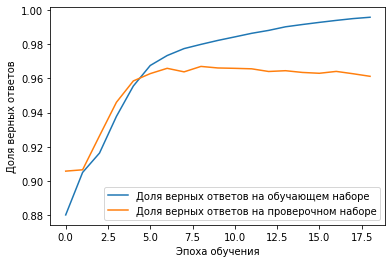

In [ ]:
# график прогрессии обучения нейросети в Matplotlib
plt.plot(view_sem.history['accuracy'], 
         label='Доля верных ответов на обучающем наборе')
plt.plot(view_sem.history['val_accuracy'], 
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend(loc='best')
plt.show()

In [ ]:
# Вычисляем результаты сети на тестовом наборе
scores = model_sem.evaluate(x_sem_test, y_sem_test, verbose=1, return_dict=True)
# scores состоит из двух знанчений
# scores[0] - loss сети на тестовой выборке
# scores[1] - процент правильно распознанных примеров на тестовой выборке
print(scores)
print("Доля верных ответов на тестовых данных, в процентах: ", round(scores['accuracy'] * 100, 4), "%", sep="")

11/11 [==============================] - 0s 12ms/step - loss: 0.1053 - accuracy: 0.9695
{'loss': 0.10527117550373077, 'accuracy': 0.9695441722869873}
Доля верных ответов на тестовых данных, в процентах: 96.9544%


In [ ]:
# предсказываем и выводим результат на экран
b = 7
prediction_p = model_sem.predict(X_train_zero[b, None])
print(prediction_p.round(0)[0].argmax(axis=1) + 1)
print(y_train_all[b])

[1 7 3 3 2 2 1 3 1 1 1 3 1 1 1 1 1 1 1 1 1 3 1 1 1 1 1 1 3 1 1 1 1 1 1 4 4
 7 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 6 7 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 3 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
[7, 7, 7, 3, 2, 2, 1, 3, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 4, 4, 7, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 7, 7, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1]


In [ ]:
# сохраняем веса
model_sem.save_weights('/content/drive/My Drive/Colab Notebooks/NLP course/model_NER.h5')

# Создаем нейросеть (Вариант LSTM) + метрика  Categorical

In [ ]:
# настройки с которыми происходили изменения, пробы, тесты
embedding_size = 100
count_lstm = 100

In [ ]:
model_sem_2 = Sequential()
model_sem_2.add(Embedding(num_characters, embedding_size, input_length=sent_len))
model_sem_2.add(Bidirectional(LSTM(count_lstm, return_sequences=True)))
model_sem_2.add(LSTM(count_lstm*2, return_sequences=True))
model_sem_2.add(Dropout(0.3))
#model_sem.add(Dense(embedding_size*2, activation='relu'))
#model_sem.add(Dropout(0.2))
model_sem_2.add(Dense(len(index_color), activation='softmax')) 

model_sem_2.compile(loss='categorical_crossentropy', metrics='categorical_accuracy', optimizer=Adam(lr=1e-3)) # было num_thresholds=200 
model_sem_2.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 200, 100)          1500000   
_________________________________________________________________
bidirectional_2 (Bidirection (None, 200, 200)          160800    
_________________________________________________________________
lstm_5 (LSTM)                (None, 200, 200)          320800    
_________________________________________________________________
dropout_2 (Dropout)          (None, 200, 200)          0         
_________________________________________________________________
dense_2 (Dense)              (None, 200, 7)            1407      
Total params: 1,983,007
Trainable params: 1,983,007
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# настройка CallBack - оценивает Точность Валидации, с минимальным значением среди 7 последних значений, возвращает лучшие веса
# взял как самый простой тип остановки, в остальных надо разбираться
early_stop = EarlyStopping(monitor='val_categorical_accuracy', patience=10, mode='max', restore_best_weights = True)


In [ ]:
epochs = 100
batch_size = 50
model_sem_2.compile(loss='categorical_crossentropy', metrics='categorical_accuracy', optimizer=Adam(lr=1e-3)) 
view_sem_2 = model_sem_2.fit(x_sem_train, y_sem_train, batch_size=batch_size, epochs=epochs, validation_split=0.2, callbacks=early_stop)

Epoch 1/100
51/51 [==============================] - 4s 72ms/step - loss: 0.4264 - categorical_accuracy: 0.8891 - val_loss: 0.3671 - val_categorical_accuracy: 0.9056
Epoch 2/100
51/51 [==============================] - 3s 55ms/step - loss: 0.3452 - categorical_accuracy: 0.9051 - val_loss: 0.3002 - val_categorical_accuracy: 0.9069
Epoch 3/100
51/51 [==============================] - 3s 55ms/step - loss: 0.2457 - categorical_accuracy: 0.9224 - val_loss: 0.2197 - val_categorical_accuracy: 0.9319
Epoch 4/100
51/51 [==============================] - 3s 56ms/step - loss: 0.1825 - categorical_accuracy: 0.9425 - val_loss: 0.1682 - val_categorical_accuracy: 0.9486
Epoch 5/100
51/51 [==============================] - 3s 55ms/step - loss: 0.1315 - categorical_accuracy: 0.9586 - val_loss: 0.1355 - val_categorical_accuracy: 0.9583
Epoch 6/100
51/51 [==============================] - 3s 56ms/step - loss: 0.1000 - categorical_accuracy: 0.9682 - val_loss: 0.1207 - val_categorical_accuracy: 0.9643
Epoc

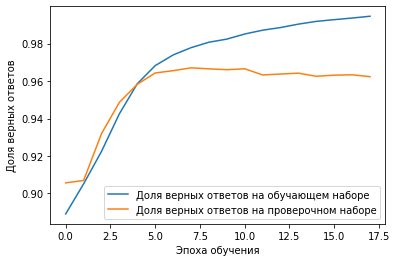

In [ ]:
# график прогрессии обучения нейросети в Matplotlib
plt.plot(view_sem_2.history['categorical_accuracy'], 
         label='Доля верных ответов на обучающем наборе')
plt.plot(view_sem_2.history['val_categorical_accuracy'], 
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend(loc='best')
plt.show()

In [ ]:
# Вычисляем результаты сети на тестовом наборе
scores = model_sem_2.evaluate(x_sem_test, y_sem_test, verbose=1, return_dict=True)
# scores состоит из двух знанчений
# scores[0] - loss сети на тестовой выборке
# scores[1] - процент правильно распознанных примеров на тестовой выборке
print(scores)
print("Доля верных ответов на тестовых данных, в процентах: ", round(scores['categorical_accuracy'] * 100, 4), "%", sep="")

11/11 [==============================] - 0s 21ms/step - loss: 0.1053 - categorical_accuracy: 0.9698
{'loss': 0.10532213747501373, 'categorical_accuracy': 0.9697721004486084}
Доля верных ответов на тестовых данных, в процентах: 96.9772%


In [ ]:
# предсказываем и выводим результат на экран
b = 7
prediction_p = model_sem.predict(X_train_zero[b, None])
print(prediction_p.round(0)[0].argmax(axis=1) + 1)
print(y_train_all[b])

[1 7 3 3 2 2 1 3 1 1 1 3 1 1 1 1 1 1 1 1 1 3 1 1 1 1 1 1 3 1 1 1 1 1 1 4 4
 7 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 6 7 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 3 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
[7, 7, 7, 3, 2, 2, 1, 3, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 4, 4, 7, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 7, 7, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1]


In [ ]:
# сохраняем веса
model_sem.save_weights('/content/drive/My Drive/Colab Notebooks/NLP course/model_NER_auc.h5')

# Метрика и её график по классам

In [ ]:
y_sem_pred = model_sem.predict(x_sem_test)

In [ ]:
xxx = np.argmax(y_sem_test, axis=-1).reshape(351*200)
yyy = np.argmax(y_sem_pred, axis=-1).reshape(351*200)

In [ ]:
print(classification_report(xxx, yyy, target_names=index_color))

                        precision    recall  f1-score   support

                 Пусто       0.98      0.99      0.98     63766
              Личность       0.90      0.76      0.82      1441
               Локация       0.92      0.87      0.90      1996
   Организация, группа       0.80      0.72      0.76      1241
                  Дата       0.84      0.85      0.85       703
        Национальность       0.78      0.73      0.75       375
Звание, профессия, чин       0.70      0.56      0.62       678

              accuracy                           0.97     70200
             macro avg       0.85      0.78      0.81     70200
          weighted avg       0.97      0.97      0.97     70200

